In [2]:
import pandas as pd
import numpy as np 
from numpy import linspace,hstack


import warnings
warnings.filterwarnings('ignore')


import matplotlib.pyplot as plt
from pylab import plot,show,hist, rcParams
rcParams['figure.figsize'] = 10, 6


from scipy.stats.kde import gaussian_kde

#  Домашнее задание по NLP # 1 [100 баллов]
## Классификация по тональности 

В этом домашнем задании вам предстоит классифицировать по тональности отзывы на банки с сайта banki.ru.

Данные содержат непосредственно тексты отзывов, некоторую дополнительную информацию, а также оценку по шкале от 1 до 5. 

Тексты хранятся в json-ах в массиве responses.

# Реализация

### Загрузка данных

In [3]:
df = pd.read_json('banki_responses.json', lines=True)

In [4]:
df.shape

(201030, 10)

In [5]:
df.head(3)

,author,bank_license,bank_name,city,datetime,num_comments,rating_grade,rating_not_checked,text,title
0,e.novikova,лицензия № 1623,ВТБ 24,г. Воронеж,2015-06-08 11:06:56,0,5.0,True,Здравствуйте! Хотелось бы выразить благодарно...,Ипотека на 5+
1,KZN\Vorontsova_NA,лицензия № 2289,Русский Стандарт,г. Казань,2015-06-06 18:17:52,0,2.0,True,Уважаемые представители департамента по работе...,ЗВОНКИ СОСЕДЯМ
2,Evgenia15,лицензия № 2307,Союз,г. Санкт-Петербург,2015-06-07 19:08:33,0,2.0,True,Здравствуйте. Столкнулась с такой ситуацией. в...,Ложная информация!!!!


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201030 entries, 0 to 201029
Data columns (total 10 columns):
author                201009 non-null object
bank_license          201026 non-null object
bank_name             201030 non-null object
city                  185492 non-null object
datetime              201030 non-null datetime64[ns]
num_comments          201030 non-null int64
rating_grade          136189 non-null float64
rating_not_checked    201030 non-null bool
text                  201030 non-null object
title                 201030 non-null object
dtypes: bool(1), datetime64[ns](1), float64(1), int64(1), object(6)
memory usage: 15.5+ MB


### Небольшой preprocessing (сделаем дата сет легче)
- удалим лишние признаки
- обработаем пропуски (тоже удалим все сэмплы с пропусками)

In [7]:
#удалим лишние столбцы
df_r = df.drop(['bank_license', 'datetime', 'rating_not_checked', 'num_comments', ], axis=1)
print(df_r.shape)

(201030, 6)


In [8]:
#посмотрим на наличие/отсутствие пропусков
df_r.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201030 entries, 0 to 201029
Data columns (total 6 columns):
author          201009 non-null object
bank_name       201030 non-null object
city            185492 non-null object
rating_grade    136189 non-null float64
text            201030 non-null object
title           201030 non-null object
dtypes: float64(1), object(5)
memory usage: 10.7+ MB


In [9]:
#удалим прпуски
df_r = df_r.dropna()
print(df_r.shape)

(121876, 6)


In [10]:
df_r.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 121876 entries, 0 to 186119
Data columns (total 6 columns):
author          121876 non-null object
bank_name       121876 non-null object
city            121876 non-null object
rating_grade    121876 non-null float64
text            121876 non-null object
title           121876 non-null object
dtypes: float64(1), object(5)
memory usage: 6.5+ MB


## Часть 1. Анализ текстов [40/100]

1. Посчитайте количество отзывов в разных городах и на разные банки
2. Постройте гистограмы длин слов в символах и в словах
3. Найдите 10 самых частых:
    * слов
    * слов без стоп-слов
    * лемм 
    * существительных
4. Постройте кривые Ципфа и Хипса
5. Ответьте на следующие вопросы:
    * какое слово встречается чаще, "сотрудник" или "клиент"?
    * сколько раз встречается слова "мошенничество" и "доверие"?
6. В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру $tf-idf$, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

### 1. Посчитайте количество отзывов в разных городах и на разные банки



In [11]:
#посмотрим на кол-во уникальных городов
df_r['city'].value_counts().head(15)

г. Москва             50862
г. Санкт-Петербург    12307
г. Екатеринбург        2149
г. Новосибирск         1929
г. Нижний Новгород     1706
г. Ростов-на-Дону      1568
г. Самара              1542
г. Казань              1320
г. москва              1307
г. Челябинск           1263
г. Краснодар           1157
г. Уфа                 1072
г. Воронеж             1038
г. Красноярск          1013
г. Пермь                991
Name: city, dtype: int64

In [12]:
#немного причешем названия городов
mystopwords = ['г.', '( )', '***', '....', '...', '..', '----', ',', ',д.',]
def  rem_SW(text, mystopwords = mystopwords):
    try:
        return " ".join([w for w in text.split() if not w in mystopwords])
    except:
        return ""

In [13]:
#удалим стоп слова
df_r['city_n']= df_r.city.apply(rem_SW) 

In [14]:
#посмотрим на распределения отзовов по городам к банку и по банкам к городу
by_bank = df_r.groupby(['bank_name', 'city_n'])['author'].count()
by_city = df_r.groupby(['city_n', 'bank_name'])['author'].count()

- распределение кол-ва отзовов в разных городах о банках

In [15]:
by_city.sort_index(ascending=False).head(20)

city_n         bank_name                     
ярцево         Восточный Экспресс Банк           1
ярославль      Хоум Кредит Банк                  1
               Связной Банк                      1
               Сбербанк России                   1
               Русфинанс Банк                    1
               Русский Стандарт                  2
               Ренессанс Кредит                  1
               ОТП Банк                          1
               Киви Банк                         1
               Газпромбанк                       1
               ВТБ 24                            1
               Альфа-Банк                        1
янаул          Ренессанс Кредит                  1
ялуторовск     Ханты-Мансийский банк Открытие    1
якутск         Хоум Кредит Банк                  1
               Сбербанк России                   1
               Московский Областной Банк         1
               Банк Москвы                       1
южноуральск    Киви Банк            

- распределение кол-ва отзовов по банкам в разных городах

In [16]:
by_bank.sort_index(ascending=False).head(20)

bank_name      city_n            
Ярославич      Ярославль             1
               Москва                3
Яндекс.Деньги  Ярославль (Москва)    1
               Ярославль             1
               Череповец             1
               Челябинск             2
               Хабаровск             1
               Уфа                   1
               Уссурийск             1
               Томск                 1
               Тихорецк              1
               Тбилиси (Москва)      1
               Тамбов                2
               Стамбул               1
               Симферополь           1
               Селенгинск            1
               Севастополь           1
               Саранск               1
               Санкт-Петербург       5
               Самара                3
Name: author, dtype: int64

### 2. Постройте гистограмы длин слов в символах и в словах

In [17]:
import re
regex = re.compile("[А-Яа-я]+")

def words_re(text, regex=regex):
    try:
        return " ".join(regex.findall(text))
    except:
        return ""


df_r.text = df_r.text.str.lower()
df_r.text = df_r.text.apply(words_re)


In [18]:
len(df_r.text.iloc[0])

1079

In [19]:
#посмотрим на описательные статистики
len_data = df_r.text.apply(len)
len_data.describe()

count    121876.000000
mean       1433.388895
std        1203.119989
min           0.000000
25%         681.000000
50%        1103.000000
75%        1778.000000
max       31053.000000
Name: text, dtype: float64

#### 2.1 Гистограма кол-ва символов в текстах

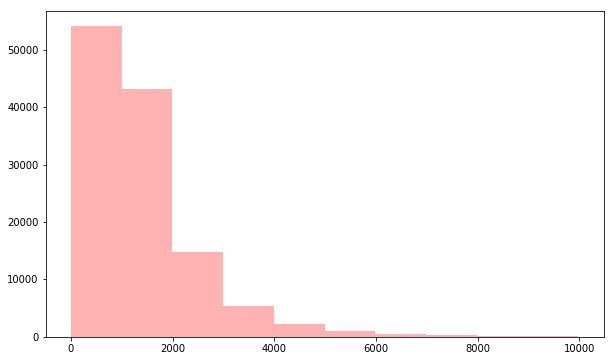

In [21]:
fig, ax = plt.subplots()

length = len_data[len_data < 10000].tolist()

n, bins, patches = ax.hist(length, color='r', alpha=.3)

fig.show()

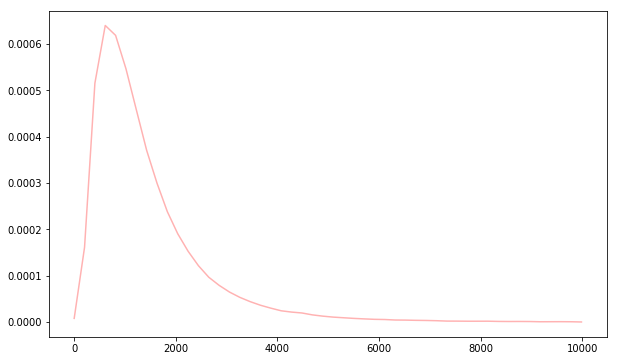

In [22]:
#выполним ядерную оценку плотности распределения длины символов с текстах
#df_r['text_len'] = df_r.text.apply(len)
my_density = gaussian_kde(length, bw_method = 0.1)

x = linspace(min(length), max(length))
plot(x, my_density(x),'r', alpha=.3)

Распределение кол-ва символов в тексте явно смещено в лево, интересно посмотреть какой вид будет иметь распределения если отбросить вылеты

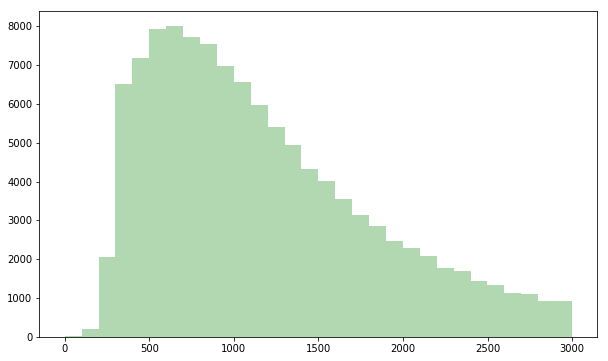

In [23]:
fig, ax = plt.subplots()

length_lt = len_data[len_data < 3000].tolist()

n, bins, patches = ax.hist(length_lt, color='g', bins=30, alpha=.3)

fig.show()

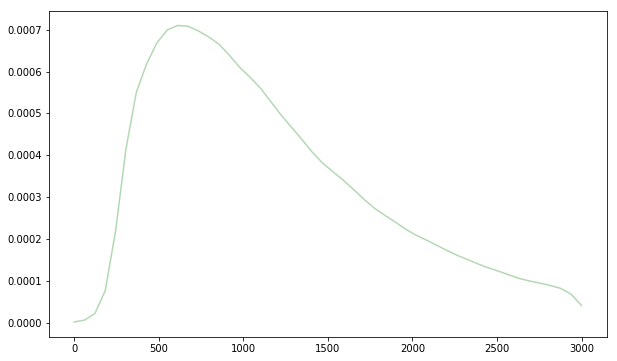

In [24]:
my_density = gaussian_kde(length_lt, bw_method = 0.1)

x = linspace(min(length_lt), max(length_lt))
plot(x, my_density(x),'g', alpha=.3)

#### 2.2 Гистограма кол-ва слов в текстах

In [25]:
words_l = []

for i in range(len(df_r['text'])):
    text = df.text.iloc[i].split()
    words_l.append(len(text))

df_r['words_l'] = words_l 
len_word = df_r['words_l']

In [26]:
df_r['words_l'].describe(percentiles=(0.1, 0.25, 0.75, 0.99))

count    121876.000000
mean        211.367603
std         182.212403
min           4.000000
10%          64.000000
25%          98.000000
50%         161.000000
75%         262.000000
99%         905.000000
max        5000.000000
Name: words_l, dtype: float64

In [27]:
#df_r[df_r['words_l'] == 5000].head()

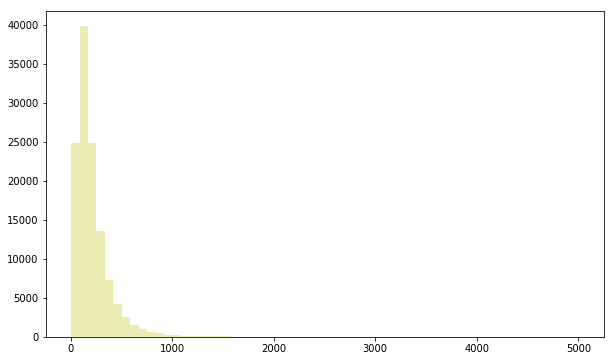

In [28]:
#посмотрим на картину вцелом, в нашей выборке есть очень серьезные выбросы (кто-то написал коментарий в 5000 слов)
fig, ax = plt.subplots()
n, bins, patches = ax.hist(len_word, color='y', bins=60, alpha=.3)
fig.show()

In [29]:
#отбросим все что больше 1000 слов
len_word_II = [x for x in df_r['words_l'] if x < 1000]

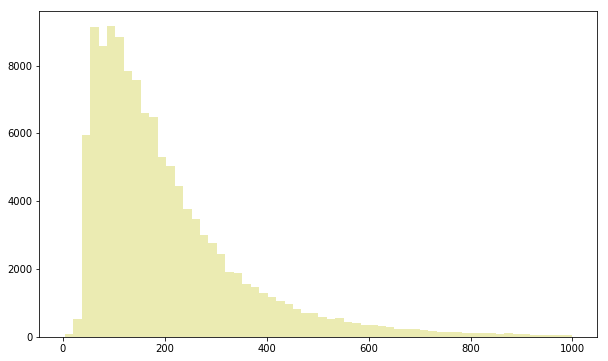

In [30]:
#посмотрим на распределение 99% наших данных
fig, ax = plt.subplots()
n, bins, patches = ax.hist(len_word_II, color='y', bins=60, alpha=.3)
fig.show()

### Вывод
Распределения частоты слов в текстах и символов в текстах смещены в лево, это вполне себе логично, обусловленно это структурой языка и словообразования

### 3. Найдите 10 самых частых:
    * слов
    * слов без стоп-слов
    * лемм 
    * существительных

#### 3.1  10 самых частых слов 

In [31]:
from collections import Counter
from tqdm import tqdm_notebook as tqdm
cnt = Counter()
n_types_s = []
n_tokens_s = []
tokens_s = []
for index, row in tqdm(df_r.iterrows(), total = len(df_r)):
    tokens_s = row['text'].split()
    cnt.update(tokens_s)
    n_types_s.append(len(cnt))
    n_tokens_s.append(sum(cnt.values()))
for i in cnt.most_common(10):
    print(i)

HBox(children=(IntProgress(value=0, max=121876), HTML(value='')))


('в', 1039908)
('и', 844370)
('не', 661240)
('на', 547841)
('что', 499692)
('я', 447279)
('с', 358067)
('по', 288214)
('мне', 252743)
('банка', 220933)


#### 3.2  10 самых частых слов (без стоп-слов)

In [32]:
from nltk.corpus import stopwords

In [33]:
mystopwords = stopwords.words('russian')
def  remove_stopwords(text, mystopwords = mystopwords):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""

In [34]:
df_r['text_SW'] = df_r['text'].apply(remove_stopwords)

In [35]:
cnt = Counter()
n_types_SW = []
n_tokens_SW = []
tokens_SW = []
for index, row in tqdm(df_r.iterrows(), total = len(df_r)):
    tokens_SW = row['text_SW'].split()
    cnt.update(tokens_SW)
    n_types_SW.append(len(cnt))
    n_tokens_SW.append(sum(cnt.values()))
for y in cnt.most_common(10):
    print(y)

HBox(children=(IntProgress(value=0, max=121876), HTML(value='')))


('банка', 220933)
('банк', 175821)
('это', 144454)
('деньги', 100883)
('карту', 84190)
('карты', 77240)
('т', 71269)
('кредит', 67796)
('банке', 60422)
('день', 58828)


#### 3.3  10 самых частых лемм

In [36]:
from pymystem3 import Mystem

m = Mystem()
def lemmatize(text, mystem=m):
    try:
        return "".join(m.lemmatize(text)).strip()  
    except:
        return " "

In [37]:
df_r['lemma'] = df_r['text_SW'].apply(lemmatize)

In [38]:
lemmata = []
for index, row in df_r.iterrows():
    lemmata += row['lemma'].split()
cnt_l = Counter(lemmata)
for i in cnt_l.most_common(10):
    print(i)

('банк', 507084)
('карта', 259241)
('деньги', 138387)
('день', 134225)
('это', 133884)
('кредит', 128268)
('мой', 121213)
('отделение', 117356)
('который', 117104)
('клиент', 112234)


#### 3.4  10 самых частых существительных

In [39]:
import nltk
from nltk import word_tokenize, sent_tokenize
from pymorphy2 import MorphAnalyzer

In [40]:
pm2 = MorphAnalyzer()

In [41]:
words_ = []
for i in df_r['lemma']:
    words_.append(i)

In [42]:
#O(n2) — квадратичная сложность 
nouns = []

for i in words_:
    w = nltk.word_tokenize(i) 
    for i in w:      
        if 'NOUN' in pm2.parse(i)[0].tag:
            nouns.append(i)

In [43]:
cnt_n = Counter(nouns)
for i in cnt_n.most_common(10):
    print(i)

('банк', 507084)
('карта', 259241)
('деньги', 138387)
('день', 134225)
('кредит', 128268)
('отделение', 117356)
('клиент', 112234)
('сотрудник', 112031)
('счет', 98256)
('сумма', 85239)


### Вывод
Немного капитанский вывод: распределение частоты слов без стоп-слов и существительных очень близкие, в принципе это логично

### 4. Постройте кривые Ципфа и Хипса

#### 4.1 Закон Ципфа

будем работать с текстами без стоп-слов

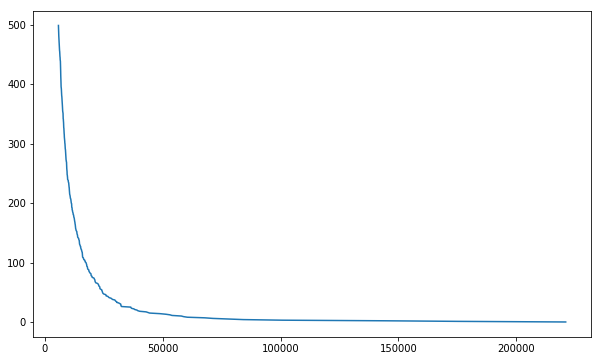

In [44]:
freqs = list(cnt.values())
freqs = sorted(freqs, reverse = True)

fig, ax = plt.subplots()
ax.plot(freqs[:500], range(500))
plt.show()

#### 4.2 Закон Хипса

будем работать с текстами без стоп-слов

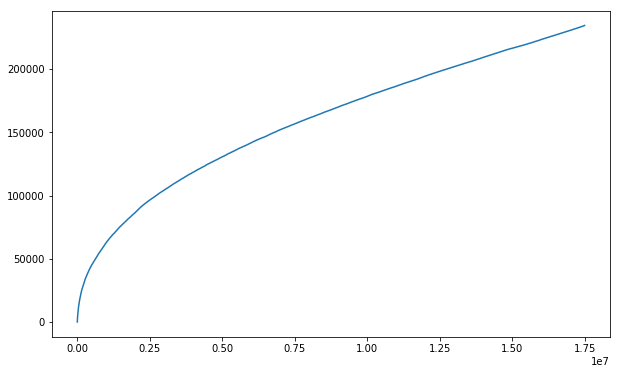

In [45]:
fig, ax = plt.subplots()
ax.plot(n_tokens_SW, n_types_SW)
plt.show()

### 5. Ответьте на следующие вопросы:
    * какое слово встречается чаще, "сотрудник" или "клиент"?
    * сколько раз встречается слова "мошенничество" и "доверие"?

* какое слово встречается чаще, "сотрудник" или "клиент"?

In [46]:
for i in cnt_l.most_common():
    if 'сотрудник' in i:
        staff = i
    elif 'клиент' in i:
        guest = i
        
if staff[1] > guest[1]:
    #print(f'Слово "СОТРУДНИК" встречается чаще чем слово "КЛИЕНТ" ')
    print('Слово "СОТРУДНИК" встречается {s} раза, это чаще чем слово "КЛИЕНТ" {c} раза'.format(s = staff[1], c = guest[1]))
else:
    #print(f'Слово "КЛИЕН" встречается чаще чем слово "СОТРУДНИК"')
    print('Слово "КЛИЕНТ" встречается {c} раза, это чаще чем слово "СОТРУДНИК" {s} раза'.format(s = guest[1], c = staff[1]))
        

Слово "КЛИЕНТ" встречается 112031 раза, это чаще чем слово "СОТРУДНИК" 112234 раза


 * сколько раз встречается слова "мошенничество" и "доверие"?

In [47]:
for i in cnt_l.most_common():
    if 'мошенничество' in i:
        cheat = i
    elif 'доверие' in i:
        trust = i
        
if cheat[1] > trust[1]:
    #print(f'Слово "СОТРУДНИК" встречается чаще чем слово "КЛИЕНТ" ')
    print('Слово "МОШЕННИЧЕСТВО" встречается {ch} раза, это чаще чем слово "ДОВЕРИЕ" {tr} раза'.format(ch = cheat[1], tr = trust[1]))
else:
    #print(f'Слово "КЛИЕН" встречается чаще чем слово "СОТРУДНИК"')
    print('Слово "ДОВЕРИЕ" встречается {tr} раза, это чаще чем слово "МОШЕННИЧЕСТВО" {ch} раза'.format(tr = trust[1], ch = cheat[1]))

Слово "МОШЕННИЧЕСТВО" встречается 1842 раза, это чаще чем слово "ДОВЕРИЕ" 1725 раза


### 6.  В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру $tf-idf$, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

- выберем данные с положительными оценками `df_pstv` и негативными `df_ngtv`

In [48]:
df_pstv = df_r[df_r['rating_grade'] == 5]
df_ngtv = df_r[df_r['rating_grade'] == 1]

In [49]:
df_pstv.head(3)

,author,bank_name,city,rating_grade,text,title,city_n,words_l,text_SW,lemma
0,e.novikova,ВТБ 24,г. Воронеж,5.0,здравствуйте хотелось бы выразить благодарност...,Ипотека на 5+,Воронеж,156,здравствуйте хотелось выразить благодарность б...,здравствовать хотеться выражать благодарность ...
9,кристина1987,ВТБ 24,г. Москва,5.0,хочу поблагодарить надежду из отдела по ипотеч...,Большая блаодарность!,Москва,475,хочу поблагодарить надежду отдела ипотечному к...,хотеть поблагодарить надежда отдел ипотечный к...
31,Мёрфи,ВТБ 24,г. Екатеринбург,5.0,выплату из асв по транспортному банку пошел по...,Знакомство с банком,Екатеринбург,201,выплату асв транспортному банку пошел получать...,выплата асв транспортный банк пойти получать в...


In [50]:
df_pstv['lemma'][0]

'здравствовать хотеться выражать благодарность банка втб г воронеж пл ленин непосредственно специалист ипотечный кредитование мещерякова юлия анатольевна это второй ипотека банк специалист вопрос подача документ быстрый принятие решение одобрение весь необходимый сумма никакой проблема выдача кредит удобно никуда нужно ходить сторонний организация нужно договариваться оценка сотрудник банк приезжать вовремя страховка оформлять выдача кредит отделение банк быстро четко слаженно мой вопрос сравнение условие юлия подробно отвечать сомнение никакой возникать какой именно банк брать выбор сбербанк втб дополнительный расход выдача кредит страховка являться обязательный условие оформление ипотека также оформлять карта привилегия бесплатно очень приятно весь свой знакомый рекомендовать обращаться юлия некоторый взять ипотека положительный отзыв спасибо хороший отношение клиент'

- посмотрим на их соотношения

In [51]:
df_pstv.shape[0], df_ngtv.shape[0] , df_pstv.shape[0]/(df_pstv.shape[0] + df_ngtv.shape[0]), \
                                                                df_ngtv.shape[0]/(df_pstv.shape[0] + df_ngtv.shape[0])

(22369, 64566, 0.25730718352792314, 0.7426928164720769)

вывод: негативных комментариев более чем в два раза больше, либо банки плохо работают, либо `homo` подсознательно тяготеет к негативным комментариям

In [52]:
#посмотрим на распределение частоты слов для корпуса позитивных текстов
cnt_p = Counter()
n_types_p = []
n_tokens_p = []
tokens_p = []
for index, row in tqdm(df_pstv.iterrows(), total = len(df_pstv)):
    tokens_p = row['lemma'].split()
    cnt_p.update(tokens_p)
    n_types_p.append(len(cnt_p))
    n_tokens_p.append(sum(cnt_p.values()))
for i in cnt_p.most_common(10):
    print(i)

HBox(children=(IntProgress(value=0, max=22369), HTML(value='')))


('банк', 80331)
('карта', 29087)
('очень', 22227)
('клиент', 18590)
('кредит', 18439)
('сотрудник', 17943)
('это', 16952)
('отделение', 15415)
('день', 15303)
('который', 15226)


In [53]:
#посмотрим на распределение частоты слов для корпуса негативных текстов
cnt_ng = Counter()
n_types_ng = []
n_tokens_ng = []
tokens_p = []
for index, row in tqdm(df_ngtv.iterrows(), total = len(df_ngtv)):
    tokens_ng = row['lemma'].split()
    cnt_ng.update(tokens_ng)
    n_types_ng.append(len(cnt_ng))
    n_tokens_ng.append(sum(cnt_ng.values()))
for i in cnt_ng.most_common(10):
    print(i)

HBox(children=(IntProgress(value=0, max=64566), HTML(value='')))


('банк', 284296)
('карта', 144508)
('деньги', 84702)
('день', 78720)
('кредит', 75763)
('это', 75498)
('мой', 75436)
('который', 68837)
('сотрудник', 65794)
('отделение', 64685)


In [54]:
#df_r['lemma'] = df_pstv['text_SW'].apply(lemmatize)

#### 6.1 Используем меру $tf-idf$, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5)

In [55]:
words_pstv = []
for i in df_pstv['lemma']:
    words_pstv.append(i)

In [56]:
pstv_w = []

for i in words_pstv:
    q = nltk.word_tokenize(i)
    pstv_w.append(q)

In [57]:
trash = []

for i in range(len(pstv_w)):
    for t in pstv_w[i]:
        trash.append(t)
        

In [58]:
import collections
import math

ii = []
def tf(text):

    tf_ = collections.Counter(text)
    for i in tf_:
        
        tf_[i] = tf_[i]/float(len(text))
    
    for i in tf_.most_common(10):
        ii.append(i)
        print(i)

In [59]:
def idf(word, corpus):
        return math.log10(len(corpus)/sum([1.0 for i in corpus if word in i]))

In [60]:
tf(trash)

('банк', 0.03279088022395325)
('карта', 0.011873228679764078)
('очень', 0.009072996660539628)
('клиент', 0.00758838385384585)
('кредит', 0.007526746093655923)
('сотрудник', 0.007324280338330074)
('это', 0.006919757024765725)
('отделение', 0.006292358101508002)
('день', 0.0062466400277247465)
('который', 0.006215208851998758)


In [61]:
#ii[:5]

In [62]:
for y in range(len(ii)):
    ii[y][0]
    r = idf(ii[y][0], trash)
    
    print(ii[y][0], r)

банк 1.3667429727873006
карта 1.923836494787097
очень 2.0406110622665925
клиент 2.093694956120591
кредит 1.8797124990146035
сотрудник 2.1352108378988275
это 1.9944158189403964
отделение 2.201102057138658
день 1.933630480957416
который 2.1591924125658046


#### 6.2 Используем меру $tf-idf$, для того, чтобы найти ключевые слова и биграмы для отрицательных отзывов (с оценкой 1)

In [63]:
WN = []
for i in df_ngtv['lemma']:
    WN.append(i)

In [64]:
n_w = []

for i in WN:
    q = nltk.word_tokenize(i)
    n_w.append(q)

In [65]:
trash_n = []

for i in range(len(n_w)):
    for t in n_w[i]:
        trash_n.append(t)

In [66]:
tf(trash_n)

('банк', 0.028875375154091346)
('карта', 0.014677388048961055)
('деньги', 0.008603012445837596)
('день', 0.007995432690330047)
('кредит', 0.007695096124459798)
('это', 0.007668180605367604)
('мой', 0.007661883389579997)
('который', 0.006991636180186095)
('сотрудник', 0.006682564766610456)
('отделение', 0.00656992585840954)


In [67]:
for y in range(len(ii)):
    ii[y][0]
    r = idf(ii[y][0], trash_n)
    
    print(ii[y][0], r)

банк 1.4005135661388963
карта 1.8324025755019502
очень 2.6969070593071023
клиент 2.1924367120874972
кредит 1.9026570826046216
сотрудник 2.17499082021726
это 1.954531572981748
отделение 2.182365683806589
день 1.7783383629790301
который 2.132863177481311
банк 1.4005135661388963
карта 1.8324025755019502
деньги 2.065236662360723
день 1.7783383629790301
кредит 1.9026570826046216
это 1.954531572981748
мой 2.084163358152373
который 2.132863177481311
сотрудник 2.17499082021726
отделение 2.182365683806589


In [60]:
### Теперь посчитаем tf-idf 

In [68]:
def tfidf(corpus):

    def tf(text):

        tf_ = Counter(text)

        for i in tf_:

            tf_[i] = tf_[i]/float(len(text))

        return tf_

    def idf(word, corpus):

        return math.log10(len(corpus)/sum([1.0 for i in corpus if word in i]))

 

    d_list = []

    for text in corpus:

        tf_idf_ = {}

        c_tf = tf(text)

        for word in c_tf:

            tf_idf_[word] = c_tf[word] * idf(word, corpus)

        d_list.append(tf_idf_)

    return d_list


### !!!

У меня очень долго считает tf-idf на всем корпусе, для оптимизации я решил посчитать как пример что функция работает на мини корпусе из трех текстов

In [69]:
n_ = []

for i in df_ngtv['lemma'][:2]:
    s = nltk.word_tokenize(i)
    n_.append(s)

In [70]:
print(tfidf(n_))


[{'июнь': 0.0, 'москва': 0.0, 'отделение': 0.0, 'адрес': 0.004703593682249706, 'смоленский': 0.002351796841124853, 'сенной': 0.002351796841124853, 'площадь': 0.002351796841124853, 'около': 0.004703593682249706, 'счет': 0.0, 'вносить': 0.002351796841124853, 'средство': 0.007055390523374559, 'размер': 0.002351796841124853, 'рубль': 0.002351796841124853, 'конец': 0.002351796841124853, 'операция': 0.0, 'банкомат': 0.009407187364499412, 'зависать': 0.002351796841124853, 'зачисление': 0.002351796841124853, 'происходить': 0.002351796841124853, 'позвонить': 0.0, 'ситифон': 0.004703593682249706, 'называть': 0.002351796841124853, 'номер': 0.002351796841124853, 'время': 0.002351796841124853, 'внесение': 0.002351796841124853, 'номинал': 0.002351796841124853, 'количество': 0.002351796841124853, 'купюра': 0.002351796841124853, 'х': 0.002351796841124853, 'руб': 0.002351796841124853, 'сотрудник': 0.004703593682249706, 'банк': 0.0, 'заверять': 0.0, 'течение': 0.0, 'банковский': 0.002351796841124853, 'д

## Часть 2. Тематическое моделирование [20/100]

1. Постройте несколько тематических моделей коллекции документов с разным числом тем. Приведите примеры понятных (интерпретируемых) тем.
2. Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить?

Эта часть задания может быть сделана с использованием gensim. 

In [85]:
import pyLDAvis.gensim
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
from gensim import corpora, models


import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import re
from nltk.corpus import stopwords
from pymystem3 import Mystem
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from nltk import FreqDist
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import  ward, dendrogram
from gensim import corpora, models
import gensim 
from gensim.models.doc2vec import *
from sklearn.pipeline import Pipeline

In [79]:
df_all = pd.concat([df_pstv, df_ngtv])

In [86]:
regex = re.compile("[А-Яа-я]+")
def words_only(text, regex=regex):
    return " ".join(regex.findall(text))


mystopwords = stopwords.words('russian') + ['это', 'наш' , 'тыс', 'млн', 'млрд', 'также',  'т', 'д']
def  remove_stopwords(text, mystopwords = mystopwords):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""

    
m = Mystem()
def lemmatize(text, mystem=m):
    try:
        return [l for l in m.lemmatize(text) if l.isalpha()]
    except:
        return []

def preprocessing(text):
    words = words_only(text)
    no_stopwords = remove_stopwords(words)
    lemmas = lemmatize(no_stopwords)
    return(lemmas)

In [87]:
%time df_all['lemmas'] = df_all.text.apply(lambda x: preprocessing(x))

CPU times: user 1min 53s, sys: 40.1 s, total: 2min 33s
Wall time: 11min 51s


In [88]:
df_all.columns

Index(['author', 'bank_name', 'city', 'rating_grade', 'text', 'title',
       'city_n', 'words_l', 'text_SW', 'lemma', 'lemmas'],
      dtype='object')

In [89]:
dictionary = corpora.Dictionary(df_all.lemmas)
corpus = [dictionary.doc2bow(text) for text in df_all.lemmas]

In [92]:
%time ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=5, id2word = dictionary, passes=20)

CPU times: user 23min 56s, sys: 16.7 s, total: 24min 12s
Wall time: 24min


In [93]:
ldamodel.print_topics(num_topics=5, num_words=4)

[(0, '0.061*"банк" + 0.024*"клиент" + 0.020*"вклад" + 0.009*"обслуживание"'),
 (1, '0.013*"банк" + 0.011*"отделение" + 0.009*"работать" + 0.009*"сказать"'),
 (2, '0.041*"банк" + 0.029*"кредит" + 0.014*"сумма" + 0.011*"договор"'),
 (3, '0.048*"карта" + 0.025*"банк" + 0.020*"деньги" + 0.016*"счет"'),
 (4, '0.021*"банк" + 0.016*"документ" + 0.015*"день" + 0.014*"отделение"')]

In [94]:
import pyLDAvis.gensim
vis = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
pyLDAvis.display(vis)

## Часть 3. Классификация текстов [40/100]

Сформулируем для простоты задачу бинарной классификации: будем классифицировать на два класса, то есть, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5). 

1.  Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Используйте ```sklearn.model_selection.train_test_split``` для разделения множества отобранных документов на обучающее и тестовое. 
2. Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных $n$-грам. 
3. Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:
* 1-ый вариант: $tf-idf$ преобразование (```sklearn.feature_extraction.text.TfidfTransformer```) и сингулярное разложение (оно же – латентый семантический анализ) (```sklearn.decomposition.TruncatedSVD```), 
* 2-ой вариант: тематические модели LDA (```sklearn.decomposition.LatentDirichletAllocation```). 

Используйте accuracy и F-measure для оценки качества классификации. 

Ниже написан примерный Pipeline для классификации текстов. 

Эта часть задания может быть сделана с использованием sklearn. 

In [95]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc

from sklearn.model_selection import  train_test_split, GridSearchCV

#### 3.1. Разобьем наш набор данных на обучающую и тестовую выборки

#### 1.1 Сформируем набор данных только из положительных и отрицательных отзывов 
- положительные == 5
- отрицательные == 1

In [6]:
#df_pstv = df_r[df_r['rating_grade'] == 5]
#df_ngtv = df_r[df_r['rating_grade'] == 1]

In [7]:
#df_all = pd.concat([df_pstv, df_ngtv])

In [96]:
#df_all['rating_grade'].value_counts()

1.0    64566
5.0    22369
Name: rating_grade, dtype: int64

Выполним бинаризацию нашего будущего таргета
- положительные комментарии будем классифицировать как единички 
- отрицательные как нолики

In [97]:
df_all["label"] = df_all.rating_grade.replace({5: 1, 1: 0}).astype(int)

Посмотрим на распределение таргета (практически соотношение 1 к 3, можно не балансировать классы)

In [98]:
df_all["label"].value_counts()

0    64566
1    22369
Name: label, dtype: int64

In [ ]:
#s = np.array(df_all.text)[0]
#print(s)
#preprocessing(s)

In [13]:
#%time df_all['lemmas'] = df_all.text.apply(lambda x: preprocessing(x))

CPU times: user 1min 57s, sys: 4.23 s, total: 2min 1s
Wall time: 14min 17s


In [174]:
#df_all = df_all.drop("lemmas", axis=1)

In [99]:
model = Word2Vec(df_all.lemmas, size=100, window=3, min_count=20, workers=4)

In [17]:
def sent_to_vec(sent, w2v = model):
    vec = np.array([w2v[w] for w in sent if w in w2v])
    if len(vec):
        return(np.mean(vec, axis=0))
    else:
        return(np.zeros(100))

In [18]:
warnings.filterwarnings(action='once')
%time df_all['mean_vec'] = df_all.lemmas.apply(lambda x: sent_to_vec(x))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


CPU times: user 2min 15s, sys: 1.67 s, total: 2min 16s
Wall time: 2min 19s


In [20]:
df_all.head()

,author,bank_name,city,rating_grade,text,title,label,lemmas,mean_vec
0,e.novikova,ВТБ 24,г. Воронеж,5.0,Здравствуйте! Хотелось бы выразить благодарно...,Ипотека на 5+,1,"[здравствовать, хотеться, выражать, благодарно...","[0.07757865, -0.039942697, 0.6359014, 0.319851..."
9,кристина1987,ВТБ 24,г. Москва,5.0,Хочу поблагодарить Надежду из отдела по ипотеч...,Большая блаодарность!,1,"[хотеть, поблагодарить, надежда, отдел, ипотеч...","[0.15079327, -0.29011187, 0.7363027, 0.6633106..."
31,Мёрфи,ВТБ 24,г. Екатеринбург,5.0,Выплату из АСВ по Транспортному Банку пошел по...,Знакомство с банком,1,"[выплата, АСВ, транспортный, банк, пойти, полу...","[0.15301657, 0.3915152, -0.121215686, -0.29479..."
40,vs1l,Ланта-Банк,г. Куйбышев,5.0,"В Куйбышевском филиале, в головном офисе прост...",Просто превосходно!,1,"[в, куйбышевский, филиал, головной, офис, прос...","[-0.17135139, 0.2593099, 0.48486114, 0.2231367..."
84,sergei.sadomskov,Сбербанк России,г. Заокский,5.0,Хочу выразить огромную благодарность сотрудник...,Благодарность сотруднику,1,"[хотеть, выражать, огромный, благодарность, со...","[-0.022466192, 0.37398213, 0.450392, -0.312406..."


In [22]:
df_raw = df_all.drop(['rating_grade', 'author', 'text', 'title', 'city', 'lemmas'], axis=1)

In [23]:
df_raw.head()

,bank_name,label,mean_vec
0,ВТБ 24,1,"[0.07757865, -0.039942697, 0.6359014, 0.319851..."
9,ВТБ 24,1,"[0.15079327, -0.29011187, 0.7363027, 0.6633106..."
31,ВТБ 24,1,"[0.15301657, 0.3915152, -0.121215686, -0.29479..."
40,Ланта-Банк,1,"[-0.17135139, 0.2593099, 0.48486114, 0.2231367..."
84,Сбербанк России,1,"[-0.022466192, 0.37398213, 0.450392, -0.312406..."


In [24]:
X = df_raw.mean_vec.tolist()
y = df_raw.label.tolist()

X, y = np.array(X), np.array(y)
#y = (y == 'Политика').astype(int)
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.25)
X_train.shape,  X_test.shape, Y_train.shape, Y_test.shape

((74266, 100), (24756, 100), (74266,), (24756,))

#### 3.2. Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных $n$-грам. 

In [25]:
penalty = ['l1', 'l2']
C = np.logspace(0, 4, 10)
hyperparameters = dict(C=C, penalty=penalty)

clf = GridSearchCV(LogisticRegression(), hyperparameters, cv=5, verbose=0)
best_model = clf.fit(X_train, Y_train)
print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])

Best Penalty: l2
Best C: 59.94842503189409


In [37]:
LR = best_model.best_estimator_
preds = LR.predict(X_test)
probas = [p[1] for p in LR.predict_proba(X_test)]
preds[:5], probas[:5]

(array([0, 1, 1, 0, 0]),
 [0.05261643961690381,
  0.9697192555731283,
  0.8969258665041967,
  0.05314073586474382,
  0.020038690214977225])

In [27]:
print('accuracy: %f' % accuracy_score(Y_test, preds))
print('roc_auc_score: %f' % roc_auc_score(Y_test, probas))
print('precision_score: %f' % precision_score(Y_test, preds))
print('recall_score: %f' % recall_score(Y_test, preds))
print('f1_score: %f' % f1_score(Y_test, preds))

accuracy: 0.940217
roc_auc_score: 0.976205
precision_score: 0.913586
recall_score: 0.861078
f1_score: 0.886555


In [35]:
from sklearn.ensemble import RandomForestClassifier

In [38]:
regr = RandomForestClassifier()
regr.fit(X_train, Y_train)


print('Результата на трейне : {:.4f}'.format(regr.score(X_train, Y_train)))
print('Результата на тесте : {:.4f}'.format(regr.score(X_test, Y_test)))

Результата на трейне : 0.9933
Результата на тесте : 0.9012


#### 3.3. Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:
* 1-ый вариант: $tf-idf$ преобразование (```sklearn.feature_extraction.text.TfidfTransformer```) и сингулярное разложение (оно же – латентый семантический анализ) (```sklearn.decomposition.TruncatedSVD```), 
* 2-ой вариант: тематические модели LDA (```sklearn.decomposition.LatentDirichletAllocation```). 